In [1]:
import os, tqdm
import numpy as np
import matplotlib.pyplot as plt
import zarr, openslide

In [2]:
#OCTREE_PATH = "/local/scratch/clmn1/octree_study_new/Experiments/pesoLarge_OctreeNCA2DSegmentation/pred"
OCTREE_PATH = "/local/scratch/clmn1/octree_study_new/Experiments/pesoLargeGroupNorm_OctreeNCA2DSegmentation/pred"
#OCTREE_PATH = "/local/scratch/clmn1/octree_study_new/Experiments/pesoLarge_loss2_contd_OctreeNCA2DSegmentation/temp"
UNET_PATH = "/local/scratch/clmn1/octree_study_new/Experiments/peso_UNet_resnet18_0_MinUNet2DSegmentation/pred/"
#MED_PATH = "/local/scratch/clmn1/octree_study_new/Experiments/peso_med_OctreeNCA2DSegmentation/pred/"

images_path = "/local/scratch/PESO/peso_training"
img_level = 1
size = (320, 320)

In [11]:
d = {}
errors = {}
for file_name in tqdm.tqdm(os.listdir(OCTREE_PATH)):
    #file_name = "pds_40_HE_15360_24640.npy"
    img_name, pos = file_name.split("_HE_")
    x, y = pos.split(".")[0].split("_")
    x, y = int(x), int(y)
    octree_pred = os.path.join(OCTREE_PATH, file_name)
    unet_pred = os.path.join(UNET_PATH, file_name)
    octree_pred = np.load(octree_pred)
    unet_pred = np.load(unet_pred)
    disagreement = np.logical_xor((octree_pred[0] > 0), (unet_pred[0] > 0)).sum()
    d[file_name] = disagreement

    if True:
        lbl_slide = openslide.open_slide(os.path.join(images_path, f"{img_name}_HE_training_mask.tif"))
        lbl = lbl_slide.read_region((int(x * lbl_slide.level_downsamples[img_level]),
                                    int(y * lbl_slide.level_downsamples[img_level])), 
                                    img_level, size)
        lbl = np.array(lbl)[:, :, 0]
        lbl = lbl == 2
        errors[file_name] = np.logical_xor((octree_pred[0] > 0)[:,:,0], lbl).sum()

  0%|          | 0/31399 [00:00<?, ?it/s]

100%|██████████| 31399/31399 [14:29<00:00, 36.10it/s]


In [21]:
sorted_d = sorted(d.items(), key=lambda x: x[1], reverse=True)
print(sorted_d[:10])

[('pds_39_HE_12800_36160.npy', 40167), ('pds_42_HE_1280_42240.npy', 36624), ('pds_6_HE_1920_51840.npy', 35799), ('pds_14_HE_8000_17920.npy', 32917), ('pds_27_HE_640_49280.npy', 32551), ('pds_14_HE_4160_39360.npy', 30637), ('pds_14_HE_12800_47680.npy', 29203), ('pds_39_HE_15360_47360.npy', 28039), ('pds_14_HE_16640_38720.npy', 26102), ('pds_42_HE_4800_45120.npy', 25413)]


In [62]:
disagreements_per_image = {}
for k, v in errors.items():
    img_name = k.split("_HE_")[0] + "_HE"
    if img_name not in disagreements_per_image:
        disagreements_per_image[img_name] = {}
    disagreements_per_image[img_name][k] = v

In [63]:
max_disagreements_per_image = {}
for k, v in disagreements_per_image.items():
    max_disagreements_per_image[k] = max(v.items(), key=lambda x: x[1])

print(max_disagreements_per_image)

{'pds_28_HE': ('pds_28_HE_12160_38400.npy', 47059), 'pds_14_HE': ('pds_14_HE_14400_24320.npy', 59912), 'pds_6_HE': ('pds_6_HE_1920_51840.npy', 47399), 'pds_42_HE': ('pds_42_HE_16320_36160.npy', 64277), 'pds_22_HE': ('pds_22_HE_3200_25920.npy', 41789), 'pds_27_HE': ('pds_27_HE_16640_34560.npy', 54273), 'pds_39_HE': ('pds_39_HE_9280_48000.npy', 66516), 'pds_41_HE': ('pds_41_HE_14080_28160.npy', 81877), 'pds_10_HE': ('pds_10_HE_13120_47040.npy', 41098)}


In [5]:
index_max_disagreement = max(d, key=d.get)
print(f"Max disagreement: {index_max_disagreement}, {d[index_max_disagreement]}")

Max disagreement: pds_39_HE_12800_36160.npy, 40167


(25600, 72320)


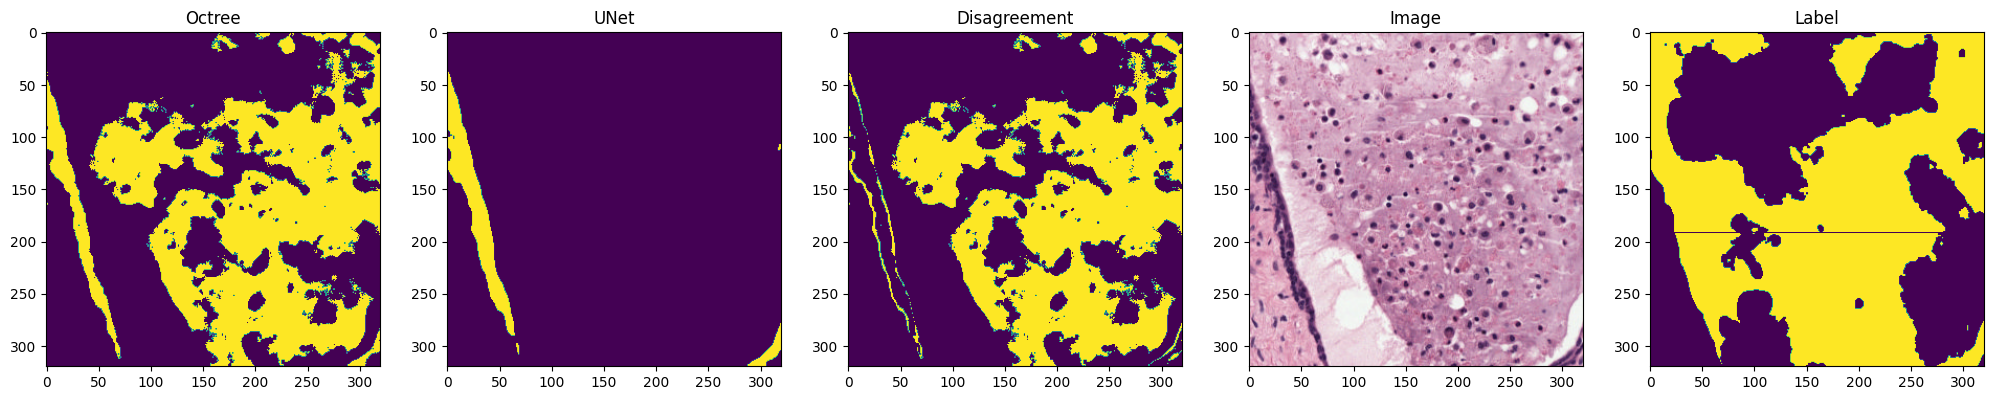

In [22]:
patient_id = "pds_39_HE"
pos_x = 12800 #- 320 *2
pos_y = 36160 #- 320
file_name = f"{patient_id}_{pos_x}_{pos_y}.npy"

img_slide = openslide.open_slide(os.path.join(images_path, f"{patient_id}.tif"))
lbl_slide = openslide.open_slide(os.path.join("/local/scratch/PESO/peso_training_masks", f"{patient_id}_training_mask.tif"))
img = img_slide.read_region((int(pos_x * img_slide.level_downsamples[img_level]),
                                int(pos_y * img_slide.level_downsamples[img_level])), 
                                img_level, size)

lbl = lbl_slide.read_region((int(pos_x * lbl_slide.level_downsamples[img_level]),
                                int(pos_y * lbl_slide.level_downsamples[img_level])), 
                                img_level, size)

print((int(pos_x * lbl_slide.level_downsamples[img_level]),
                                int(pos_y * lbl_slide.level_downsamples[img_level])))

lbl = np.array(lbl)[:, :, 0]
lbl = lbl == 2

octree_pred = os.path.join(OCTREE_PATH, file_name)
unet_pred = os.path.join(UNET_PATH, file_name)
#med_pred = os.path.join(MED_PATH, file_name)
octree_pred = np.load(octree_pred)
unet_pred = np.load(unet_pred)
#med_pred = np.load(med_pred)
plt.figure(figsize=(25, 8))

plt.subplot(1, 5, 1)
plt.title("Octree")
plt.imshow(octree_pred[0] > 0)

plt.subplot(1, 5, 2)
plt.title("UNet")
plt.imshow(unet_pred[0] > 0)

plt.subplot(1, 5, 3)
plt.title("Disagreement")
plt.imshow(np.logical_xor((octree_pred[0] > 0), (unet_pred[0] > 0)))

plt.subplot(1, 5, 4)
plt.title("Image")
#plt.imshow(med_pred[0] > 0)
plt.imshow(img)
#plt.imshow(lbl, alpha=0.5)
#plt.imshow(octree_pred[0] > 0, alpha=0.5)

plt.subplot(1, 5, 5)
plt.title("Label")
plt.imshow(lbl)


(array([0, 1], dtype=uint8), array([12425, 89975]))


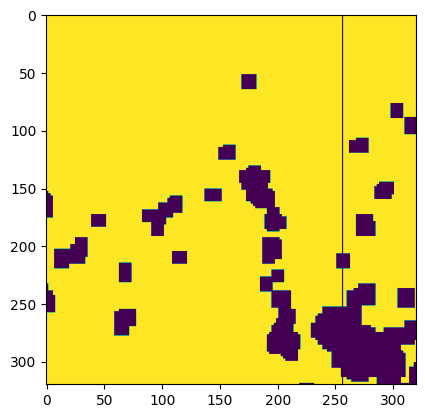

In [15]:
lbl_slide = openslide.open_slide(os.path.join("/local/scratch/PESO/peso_training_colordeconvolution", f"pds_41_colordeconvolution.tif"))

lbl = lbl_slide.read_region((int(pos_x * lbl_slide.level_downsamples[img_level]),
                                int(pos_y * lbl_slide.level_downsamples[img_level])), 
                                img_level, size)
lbl = np.array(lbl)[:,:,0]
print(np.unique(lbl, return_counts=True))
plt.imshow((lbl > 0).astype(float))

In [16]:
int(pos_x * lbl_slide.level_downsamples[img_level]), int(pos_y * lbl_slide.level_downsamples[img_level])

(28160, 56320)